In this script I go through different ways of visualizing the integrated intensity of the spectra.  The first is just straight summation of the spectra, but I also try subtracting a linear background from the spectra in order to see if that deals with the nonuniform background issue

In [112]:
from a72_utilities import *
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tifffile import imsave
import matplotlib
matplotlib.rcParams['figure.dpi'] = 200

from scipy.interpolate import interp1d
from skimage.io import imsave
from numpy.typing import ArrayLike


In [2]:
xas_data,xas_masks,xas_energies = load_registered_xas()
element_endpoints = {"Al":(76,88),"Cr":(571,581),"Fe":(703,716),"Ni":(848,864),"Ti":(452,470)}
#print(xas_energies['Cr'])


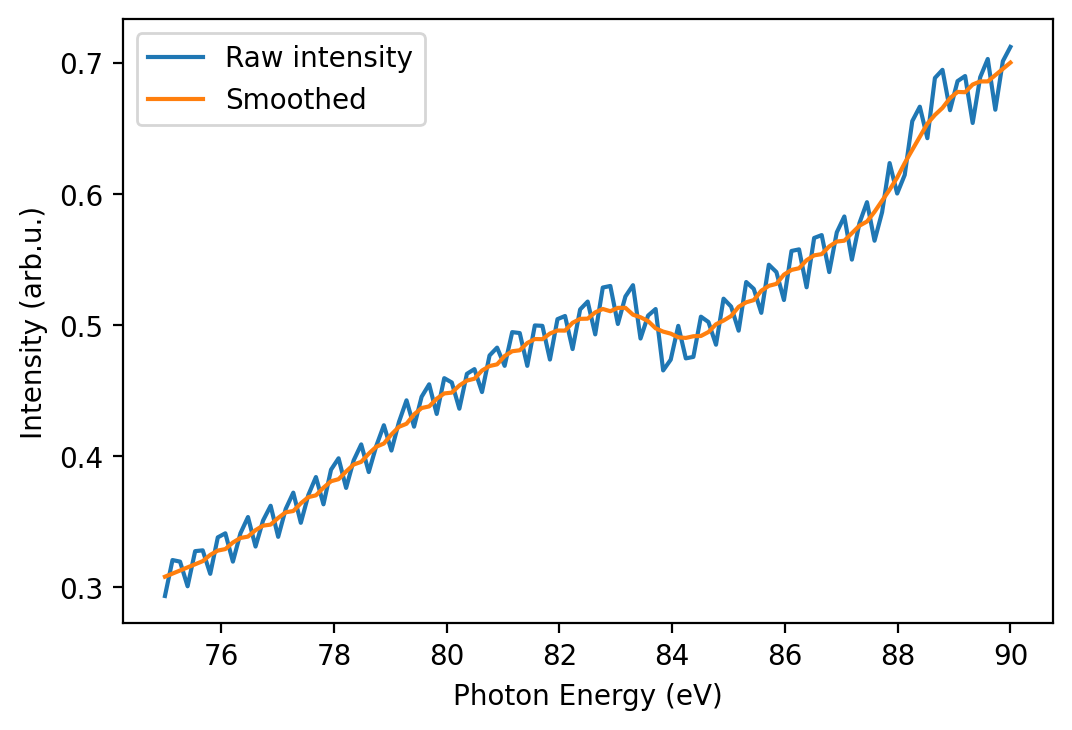

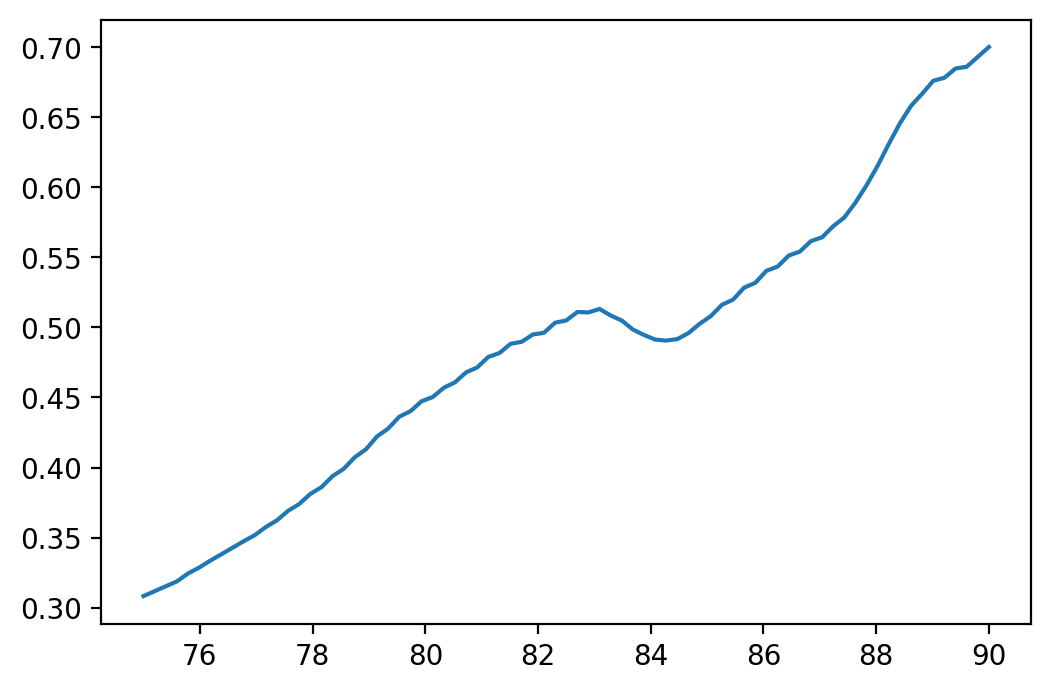

In [113]:
"""Find the undulator background for the Al2p region using the data from Jurek"""

al_background = pd.read_csv('/Users/apple/Sync/Research/Alloy 72/Al2p_beam_current_75-90eV.csv')
plt.plot(al_background['Energy'],al_background['Intensity'],label='Raw intensity')

"""Get rid of periodic variations that come from undulator variations- these aren't real according to Jurek"""
local_averaged = np.convolve(al_background['Intensity'],np.ones(10)/10,mode='valid') #only do the local averaging where the whole convolution is valid
top_end_slope = (local_averaged[-1]-local_averaged[-2]) #Find the endpoints and just pad with the local slope
bottom_end_slope = (local_averaged[1]-local_averaged[0])
padded_local_averaged = np.pad(local_averaged,(5,4))
padded_local_averaged[:5] = local_averaged[0] + np.arange(5)*top_end_slope -top_end_slope*5
padded_local_averaged[-4:] = local_averaged[-1] + np.arange(4)*bottom_end_slope

plt.plot(al_background['Energy'],padded_local_averaged,label='Smoothed')
plt.xlabel("Photon Energy (eV)")
plt.ylabel("Intensity (arb.u.)")
plt.legend()
plt.show()

spline_interp = interp1d(al_background['Energy'],padded_local_averaged)
plt.plot(xas_energies['Al'],spline_interp(xas_energies['Al']))


#make a dataframe with the smoothed data
al_background['Smoothed Intensity'] = np.round(padded_local_averaged,5)
#Uncomment to save the smoothed data to a csv
#al_background.to_csv('/Users/apple/Sync/Research/Alloy 72/Al2p background smoothed.csv',index=False)

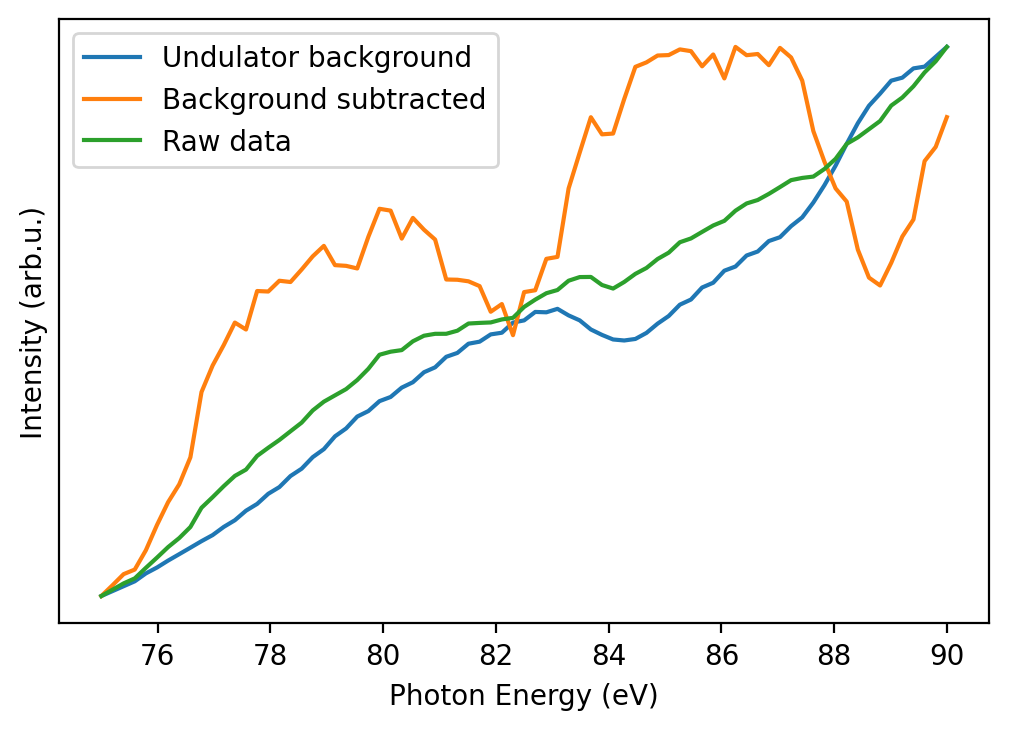

(77, 964, 964)


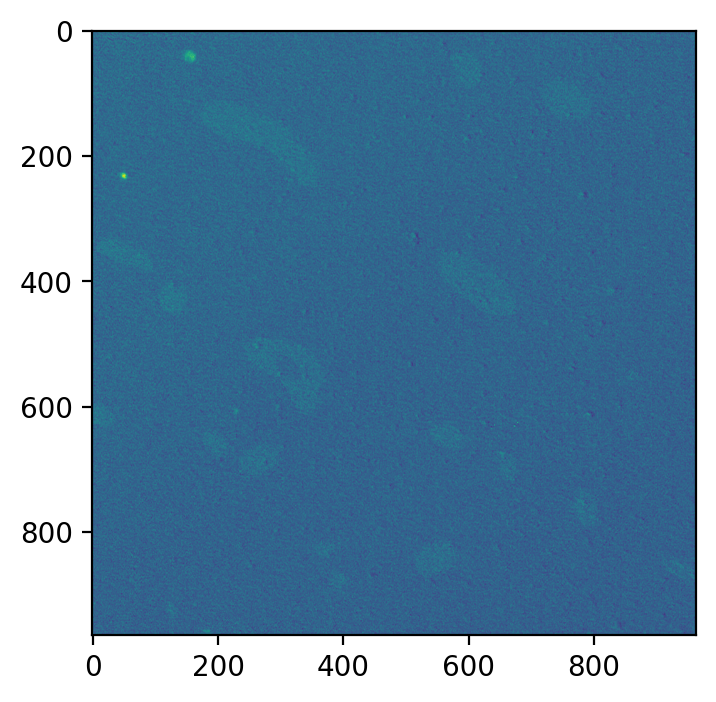

In [128]:
al_br_ones = (np.ones(xas_data['Al'].shape))*(np.reshape(spline_interp(xas_energies['Al']),(77,1,1))) #make a background array with the same shape as the xas data
al_br = trim_edges(al_br_ones)*np.average(trim_edges(xas_data['Al'][:3,:,:]),axis=0)

al_br_subtracted = trim_edges(xas_data['Al']) - al_br
plt.plot(xas_energies['Al'],normalize_array(np.average(al_br,axis=(1,2))),label='Undulator background')
plt.plot(xas_energies['Al'],normalize_array(np.average(al_br_subtracted,axis=(1,2))),label='Background subtracted')
plt.plot(xas_energies['Al'],normalize_array(np.average(xas_data['Al'],axis=(1,2))),label='Raw data')
plt.xlabel("Photon Energy (eV)")
plt.yticks([])
plt.legend()
plt.ylabel("Intensity (arb.u.)")
plt.show()

test_al, br = subtract_background(al_br_subtracted,xas_energies['Al'],bg_endpoints= element_endpoints['Al'])
print(test_al.shape)
plt.imshow(np.average(test_al,axis=0))


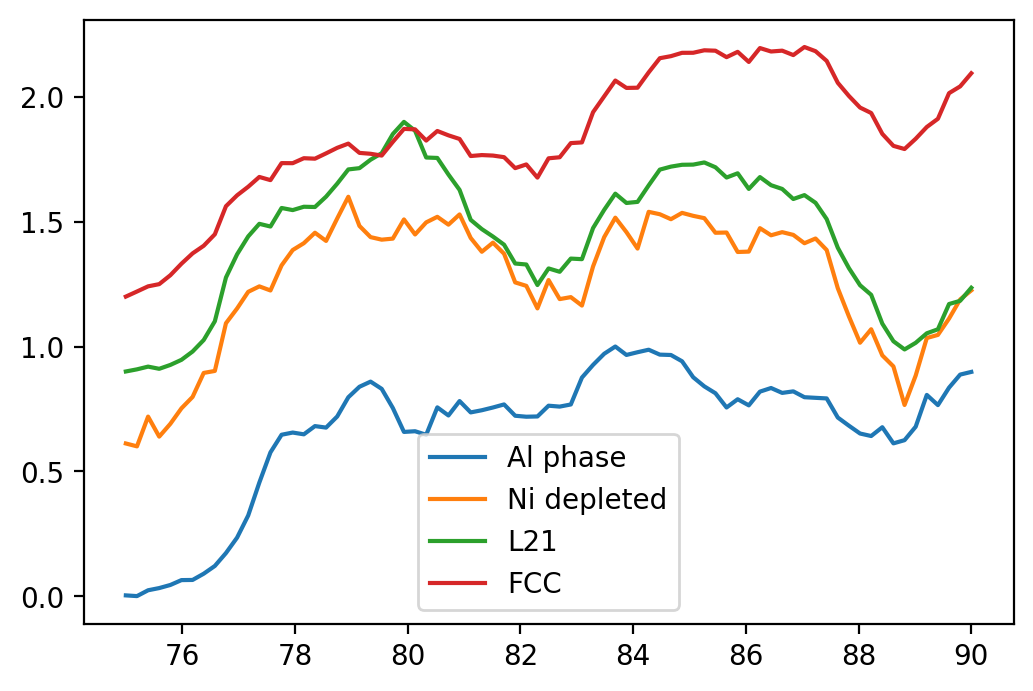

In [120]:
masks = load_phase_masks()

for i, (phase, mask) in enumerate(masks.items()):
    if phase == 'Islands':
        continue
    subtracted = mask_subtract_arr(al_br_subtracted,mask,return_nan=True)
    plt.plot(xas_energies["Al"],i*.3+normalize_array(np.nanmean(subtracted,axis=(1,2))),label=phase)
plt.legend()

(72, 1024, 1024)


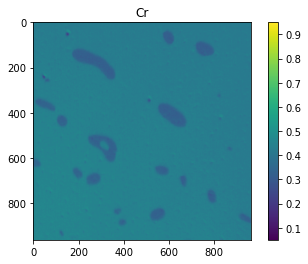

(87, 1024, 1024)


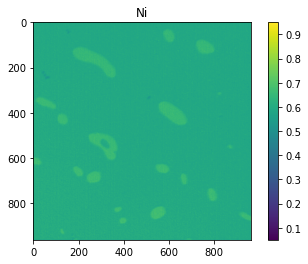

(91, 1024, 1024)


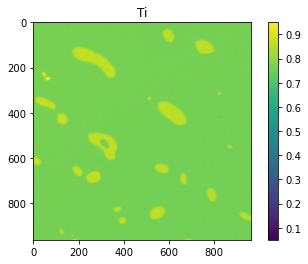

(77, 1024, 1024)


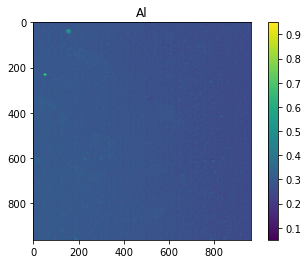

(77, 1024, 1024)


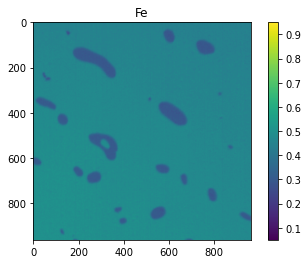

In [ ]:
"""Calculate a simple background subtraction by subtracting the average of the first three frames (the pre-edge)"""

for i, (element,xas) in enumerate(xas_data.items()):
    plt.title(element)
    print(xas.shape)
    br_subtracted = np.average(trim_edges(xas[:,:,:],border=30),axis=0)-np.average(trim_edges(xas[:3,:,:],border=30),axis=0)
    plt.imshow(normalize_array(br_subtracted),vmin=.05,vmax=.95)
    plt.colorbar()
    plt.show()

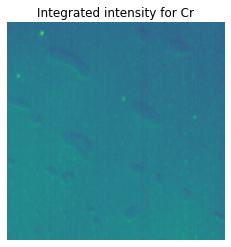

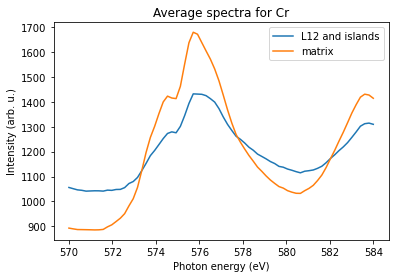

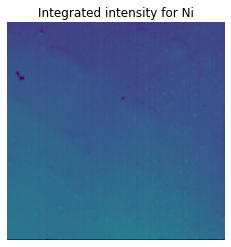

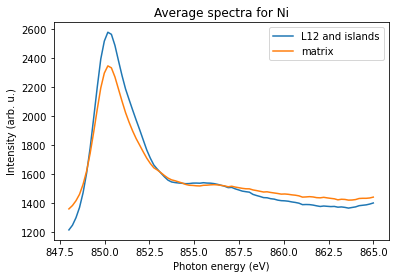

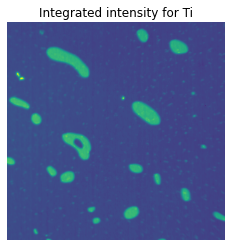

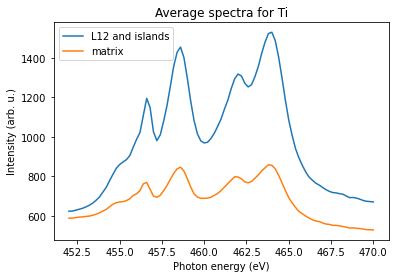

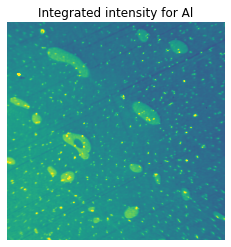

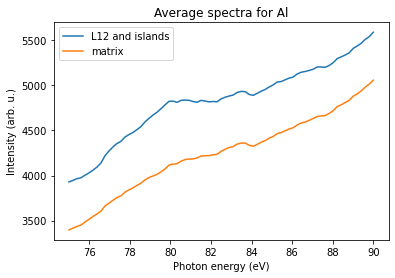

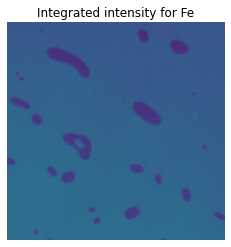

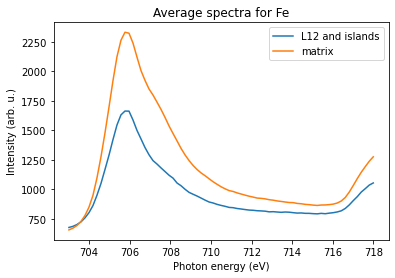

In [5]:
#plot average spectra of the matrix and l12 phases for all of the elements

for i, (element, xas) in enumerate(xas_data.items()):
    
    l12 = trim_edges(mask_subtract_arr(xas_data[element], xas_masks[element]))
    l12 = l12.astype(float)
    l12[l12 == 0.] = np.nan
    matrix = trim_edges(mask_subtract_arr(xas_data[element],np.invert(xas_masks[element])))
    matrix = matrix.astype(float)
    matrix[matrix == 0.] = np.nan
    plt.imshow(np.average(trim_edges(xas,border=30),axis=0), vmin = np.percentile(trim_edges(xas),1),vmax = np.percentile(trim_edges(xas),99))
    plt.title("Integrated intensity for " + element)
    plt.axis('off')
    plt.show()

    #plt.plot(xas_energies[element],(np.nanmean(xas,axis=(1,2))))
    plt.plot(xas_energies[element],(np.nanmean(l12,axis=(1,2))))
    plt.plot(xas_energies[element],(np.nanmean(matrix,axis=(1,2))))
    plt.xlabel("Photon energy (eV)")
    plt.ylabel("Intensity (arb. u.)")
    plt.legend(["L12 and islands","matrix"])
    plt.title("Average spectra for "+ element)
    plt.show()

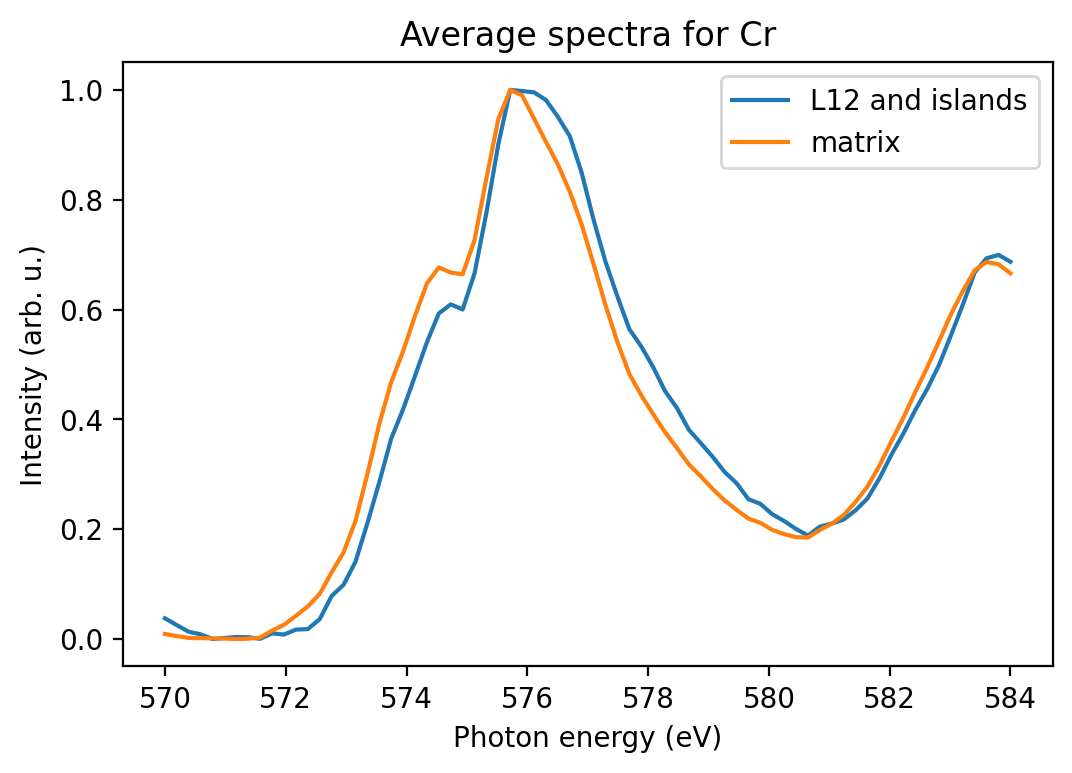

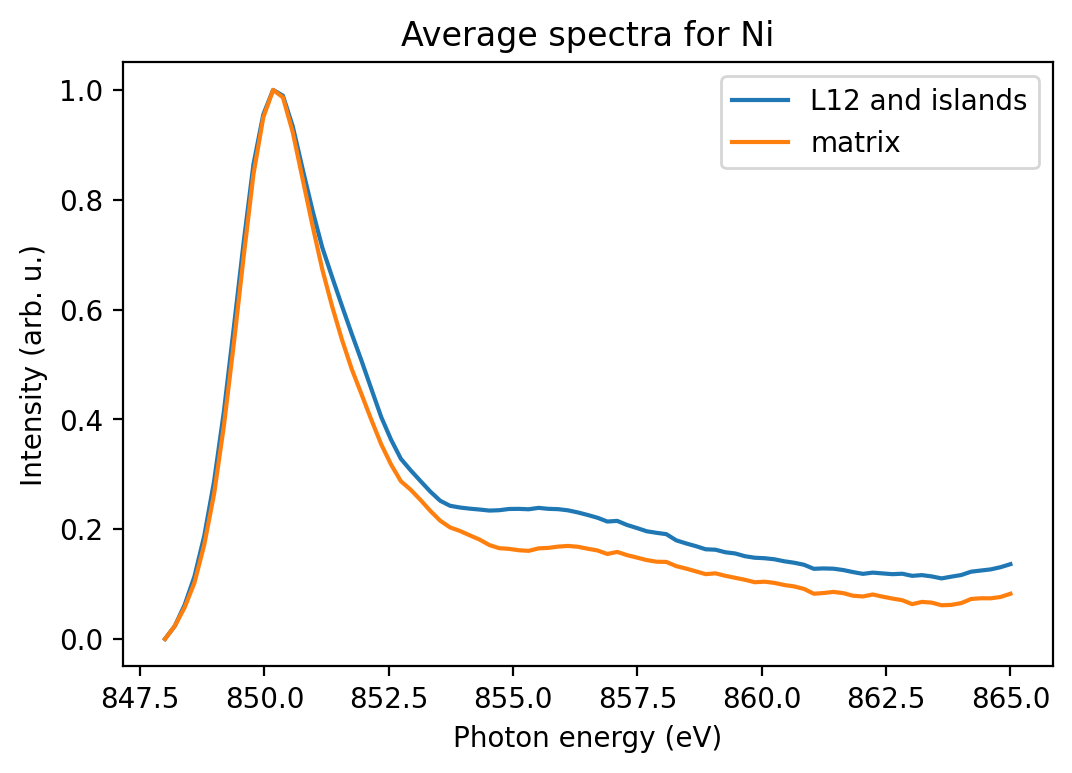

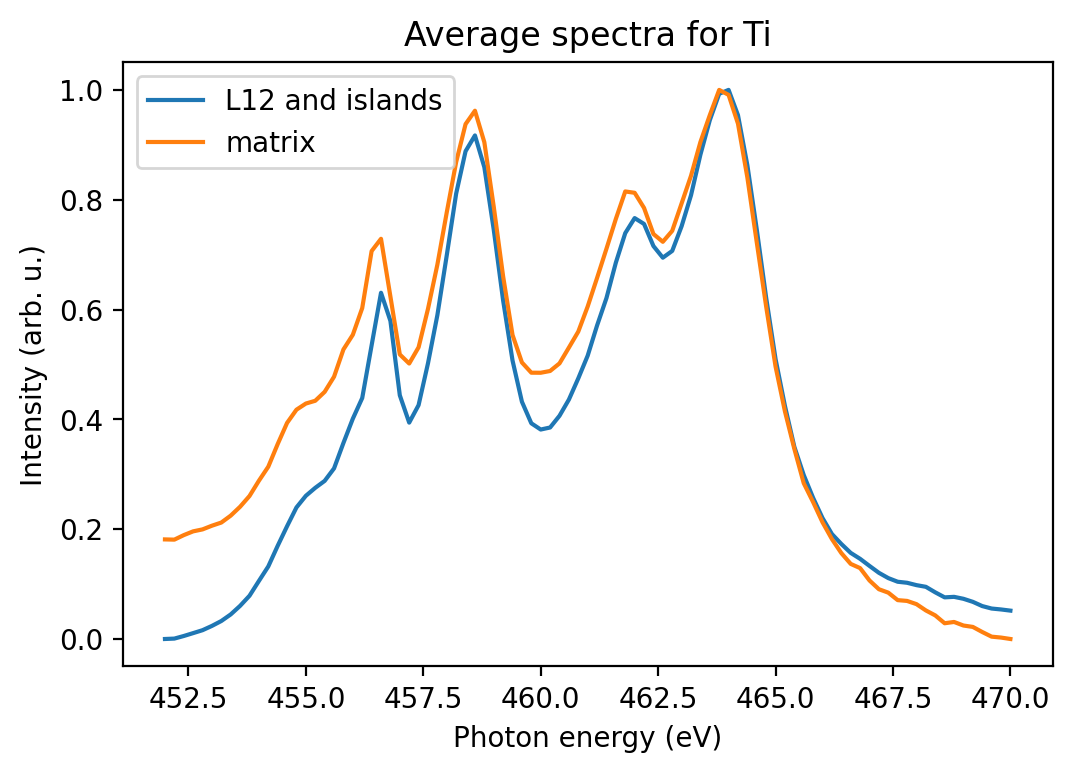

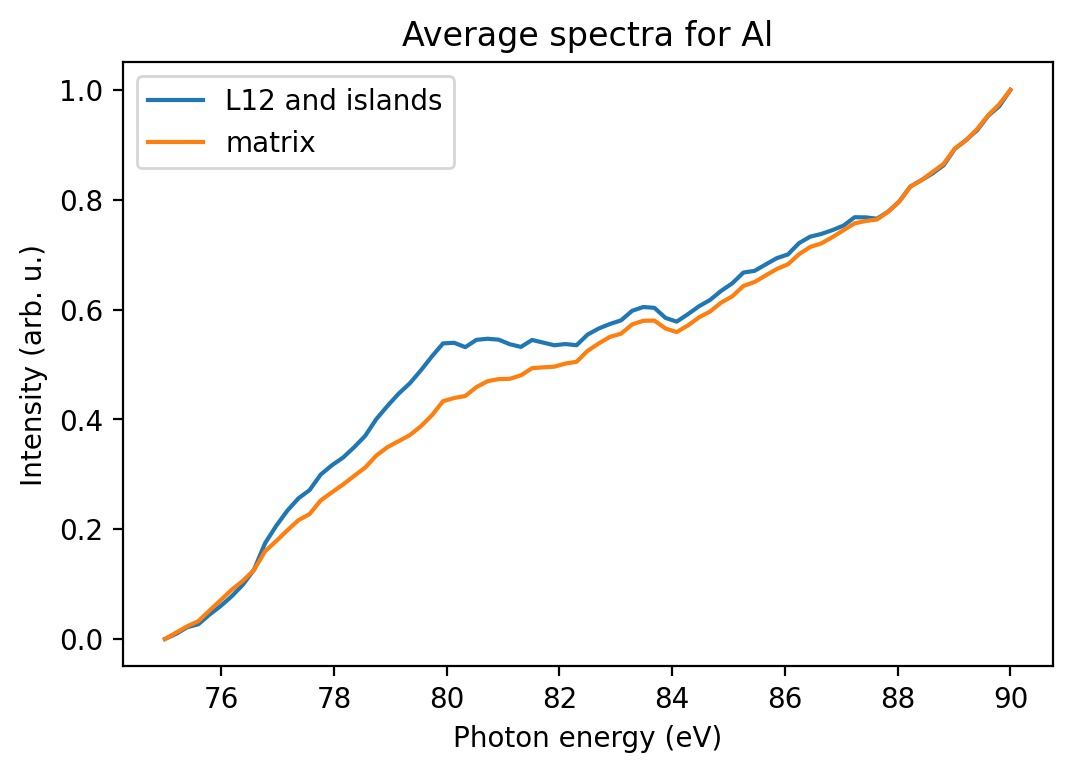

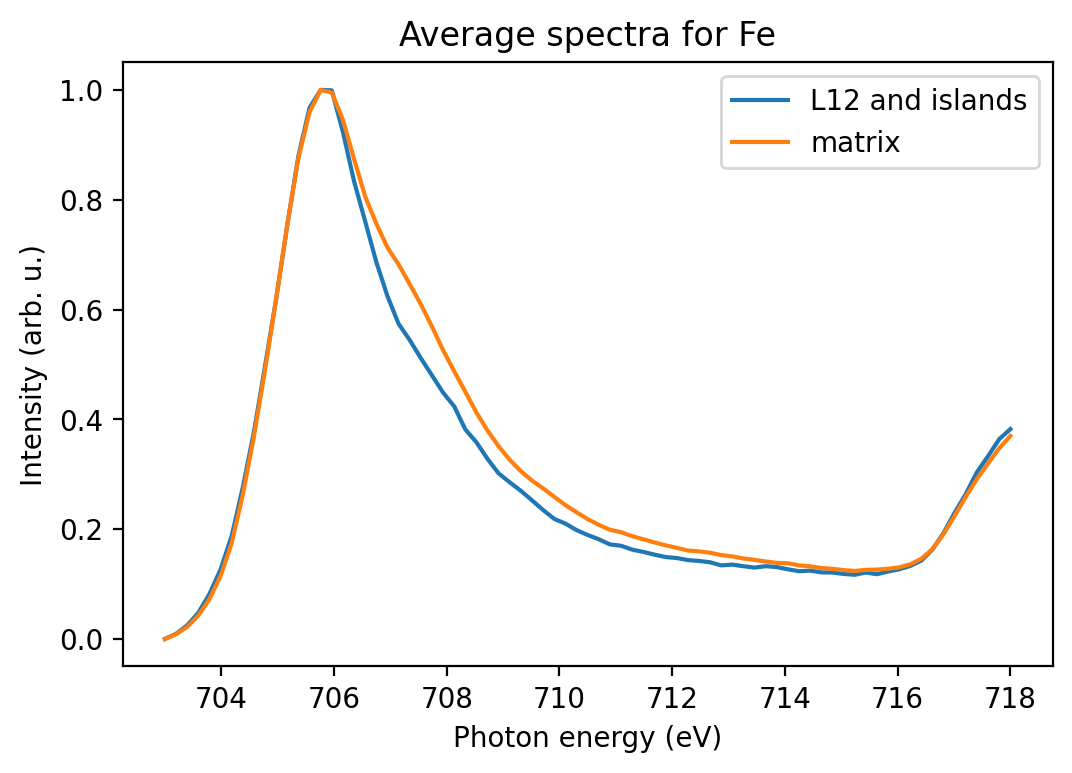

In [ ]:
#Save the data from the l12 in a .csv file so it can get put into igor

average_spectra = pd.DataFrame(index=range(200))

for i, (element, xas) in enumerate(xas_data.items()):
    
    l12 = trim_edges(mask_subtract_arr(xas_data[element], xas_masks[element]))
    l12 = l12.astype(float)
    l12[l12 == 0.] = np.nan
    matrix = trim_edges(mask_subtract_arr(xas_data[element],np.invert(xas_masks[element])))
    matrix = matrix.astype(float)
    matrix[matrix == 0.] = np.nan

    average_spectra['energy_'+element] = pd.Series(xas_energies[element])
    average_spectra['intensity_'+element+'_L21'] = pd.Series(np.nanmean(l12,axis=(1,2)))
    average_spectra['intensity_'+element+'_matrix'] = pd.Series(np.nanmean(matrix,axis=(1,2)))



    plt.plot(xas_energies[element],normalize_array((np.nanmean(l12,axis=(1,2)))))
    plt.plot(xas_energies[element],normalize_array(np.nanmean(matrix,axis=(1,2))))
    plt.xlabel("Photon energy (eV)")
    plt.ylabel("Intensity (arb. u.)")
    plt.legend(["L12","FCC"])
    plt.title("Average spectra for "+ element)
    plt.show()

average_spectra.to_csv("average_spectra.csv")

In [7]:
# test_img = xas_data["Al"]
# test_subtract, test_br = subtract_background(trim_edges(test_img,border=30))
# plt.imshow(np.sum(trim_edges(test_img,border=30),axis=0))
# plt.show()
# plt.imshow(np.sum(trim_edges(test_subtract,border=30),axis=0))
# plt.show()

The proper way to subtract the background is weird, because in some places the right edge is higher than the left edge, which shouldn't happen because absorption edges should increase monotonically

In [8]:
#plt.imshow(np.sum(test_br,axis=0))
# print(np.average(test_subtract))
# print(np.sum(test_subtract[:,10,10]))
# plt.plot(test_br[:,10,10])
# plt.plot(test_subtract[:,10,10])
# plt.plot(trim_edges(test_img,border=30)[:,10,10])
# print(np.max(np.average(test_subtract,axis=0)),np.min(np.average(test_subtract,axis=0)))

In [9]:
# test_avg = np.average(test_subtract,axis=0)
# plt.imshow(test_avg<0)
# plt.colorbar()
# plt.show()
# weird_points = trim_edges(test_img,border=30)*(test_avg<0)
# normal_points = trim_edges(test_img,border=30)*(test_avg>0)
# plt.plot(np.average(weird_points,axis=(1,2)))
# #plt.plot(np.average(normal_points,axis=(1,2)))


Cr


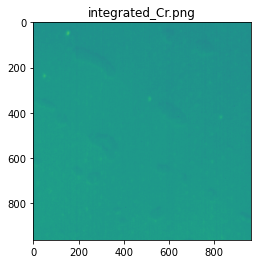

Ni


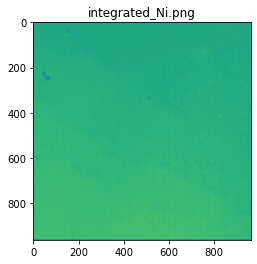

Ti


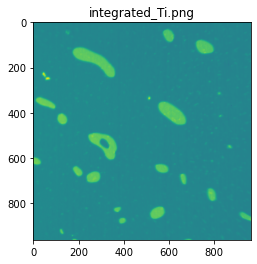

Al


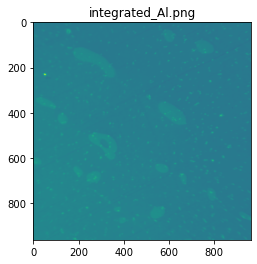

Fe


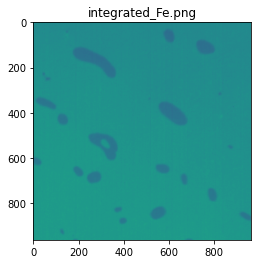

In [10]:
#Do simple summation and normalize the result for easy visualization
for (element,image) in xas_data.items():
    print(element)
    save_directory = 'results'
    filename = "integrated_"+element+'.png'
    integrated_image = np.average(image,axis=(0))
    plt.imshow(integrated_image[30:-30,30:-30])
    plt.title("integrated_"+str(element)+'.png')
    plt.show()
    imsave(os.path.join(save_directory,filename),make_16bit(integrated_image[30:-30,30:-30]))
    

Cr


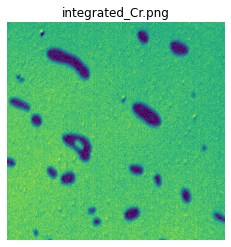

<ipython-input-11-f814a43a36cc>:28: UserWarning: results/subtracted_background_Cr.png is a low contrast image
  imsave(os.path.join(save_directory,br_filename),np.uint16(np.average(br,axis=0)))


Ni


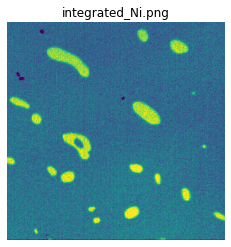

<ipython-input-11-f814a43a36cc>:28: UserWarning: results/subtracted_background_Ni.png is a low contrast image
  imsave(os.path.join(save_directory,br_filename),np.uint16(np.average(br,axis=0)))


Ti


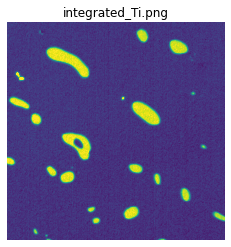

<ipython-input-11-f814a43a36cc>:28: UserWarning: results/subtracted_background_Ti.png is a low contrast image
  imsave(os.path.join(save_directory,br_filename),np.uint16(np.average(br,axis=0)))


Al


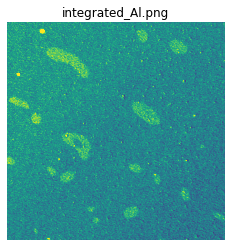

<ipython-input-11-f814a43a36cc>:28: UserWarning: results/subtracted_background_Al.png is a low contrast image
  imsave(os.path.join(save_directory,br_filename),np.uint16(np.average(br,axis=0)))


Fe


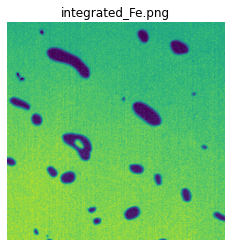

<ipython-input-11-f814a43a36cc>:28: UserWarning: results/subtracted_background_Fe.png is a low contrast image
  imsave(os.path.join(save_directory,br_filename),np.uint16(np.average(br,axis=0)))


In [11]:
"""Subtract a linear background from each spectrum in the hyperspectral images"""

for (element,image) in xas_data.items():
    print(element)
    energy_list = xas_energies[element]

    #Set up the filenames and directory where the images will be saved
    save_directory = 'results'
    filename = "subtracted_integrated_"+element+'.png'
    br_filename = "subtracted_background_"+element+'.png'


    subtracted_img, br = subtract_background(trim_edges(image,border=30),energy_list,element_endpoints[element])
    integrated_image = np.sum(subtracted_img,axis=(0))
    #deal with values that are too big or too small and lead to weird behavior
    integrated_image[integrated_image <=1 ] = 1.
    integrated_image[integrated_image >=65535] = 65535

    vmin = np.percentile(integrated_image, 1)
    vmax = np.percentile(integrated_image, 99)
    # Display the image using the 1st and 99th percentiles for intensity scaling
    plt.imshow(integrated_image, vmin=vmin, vmax=vmax)

    plt.title("integrated_"+str(element)+'.png')
    plt.axis("off")
    plt.show()

    #specifically don't normalize the array to keep the intensity information
    imsave(os.path.join(save_directory,filename),np.uint16(integrated_image))
    imsave(os.path.join(save_directory,br_filename),np.uint16(np.average(br,axis=0)))